In [35]:
import logging

# from scipy.sparse import csc_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import collections

# from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
input_dir = "/scratch/ahakobyan/pcawg_immune/"

In [3]:
import os
os.listdir(input_dir)

['GO.immune.system.process.dat', 'GO.immune.system.process.ENSEMBL.dat']

In [4]:
os.listdir('npy_files')

['exps_log.npy',
 'bars.png',
 '.ipynb_checkpoints',
 'descriptive.ipynb',
 'pcawg_log.npy',
 'immune_exps_log.npy',
 'non_immune_exps_log.npy']

### Reading the tcga expressions, log-transforming and saving the into a numpy file

In [6]:
# all_exps = pd.read_csv(input_dir + "tcga_all_exps.subset.dat", sep = "\t", index_col = 0, header = None) 
# tcga_gene_names = pd.read_csv(input_dir + "TCGA_ensg_names.dat", sep = "\t", header = None, index_col = 0)

# all_exps.columns = tcga_gene_names.index

# common_gene_names = pd.read_csv(input_dir + "common_tcga_pcawg_genes.dat", sep = "\t", header = None, index_col = 0)

# all_exps_sub = all_exps[common_gene_names.index]

# exps_np = all_exps_sub.to_numpy() 

In [5]:
# all_exps_sub.shape

NameError: name 'all_exps_sub' is not defined

In [26]:
# del(all_exps)
# del(all_exps_sub)

NameError: name 'all_exps' is not defined

In [5]:
# exps_log = np.log(exps_np + 1)

# with open('npy_files/exps_log.npy', 'wb') as f:
#     np.save(f, exps_log)

In [7]:
exps_log = np.load('npy_files/exps_log.npy')

In [8]:
len(common_gene_names)

52210

In [5]:
immune_system_process_genes = pd.read_csv(input_dir + "GO.immune.system.process.ENSEMBL.dat", header = None)
immune_system_process_genes.head()

0
0  ENSG00000175899
1  ENSG00000097007
2  ENSG00000184009
3  ENSG00000072110
4  ENSG00000135503

In [6]:
common_immune_genes = list(set.intersection(set(immune_system_process_genes.iloc[:, 0]), 
                                            set(common_gene_names.index)))
common_immune_genes

NameError: name 'common_gene_names' is not defined

In [45]:
# immune_exps_sub = all_exps_sub[common_immune_genes]

# immune_exps_np = immune_exps_sub.to_numpy() 

# immune_exps_log = np.log(immune_exps_np + 1)

# with open('npy_files/immune_exps_log.npy', 'wb') as f:
#     np.save(f, immune_exps_log)

In [8]:
immune_exps_log = np.load('npy_files/immune_exps_log.npy')

In [36]:
# all_exps_sub.head()
# non_immune_exps_sub = all_exps_sub.loc[:, ~all_exps_sub.columns.isin(common_immune_genes)]
# non_immune_exps_np = non_immune_exps_sub.to_numpy() 

# non_immune_exps_log = np.log(non_immune_exps_np + 1)

# with open('npy_files/non_immune_exps_log.npy', 'wb') as f:
#     np.save(f, non_immune_exps_log)

In [9]:
non_immune_exps_log = np.load('npy_files/non_immune_exps_log.npy')

### Embedding using SVD

In [8]:
embedder_svd = TruncatedSVD(n_components=200) 
# mod_exps = embedder_svd.fit_transform(exps_np)


In [9]:
mod_log_exps = embedder_svd.fit_transform(exps_log)

In [10]:
# unique_samples = pd.read_csv(input_dir + 'trimmed_unique_sample_names.dat', header = None)

spp_table = pd.read_csv(input_dir + 'imm_subtypes_sorted.tsv', sep = '\t', header = None)

### Feauture space and response variables

In [11]:
# X = mod_exps
# X_log = mod_log_exps
y = spp_table[2].to_numpy()


In [12]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=1121218
# )

# X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
#     X_log, y, test_size=0.3, random_state=1121218
# )

NameError: name 'X_log' is not defined

### Hyperparameter tuning

In [13]:
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

In [14]:
param_dist = {
    "max_depth": [7, None],
    "max_features": randint(1, 30),
    "min_samples_split": randint(2, 30),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

In [15]:
rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=rng
)

NameError: name 'clf' is not defined

In [20]:
rsh.fit(X_log_train, y_log_train)
rsh.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 25,
 'min_samples_split': 18}

In [21]:
rsh.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=25,
                       min_samples_split=18,
                       random_state=RandomState(MT19937) at 0x2ABDEF33B840)

In [23]:
y_log_pred = rsh.predict(X_log_test)

In [26]:
f1_score(y_log_test, y_log_pred, average="weighted")

0.730201579428932

In [28]:
precision_score(y_log_test, y_log_pred, average="weighted")

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7309122052811344

In [29]:
recall_score(y_log_test, y_log_pred, average="weighted")

0.7405825242718447

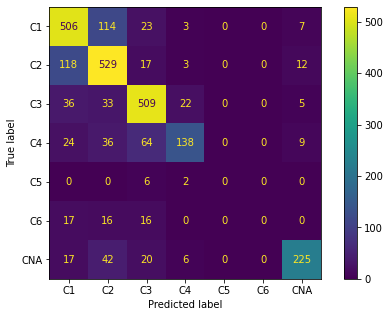

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_log_test, y_log_pred),
    display_labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CNA'],
)
cmp.plot(ax=ax)

In [35]:
precision_score(y_log_test, y_log_pred, labels = ["C4", "C5", "C6"],  average="micro")

0.7931034482758621

In [36]:
recall_score(y_log_test, y_log_pred, labels = ["C4", "C5", "C6"],  average="micro")

0.42073170731707316

### Making a custom scoring function


In [12]:
custom_f1 = make_scorer(
    f1_score, greater_is_better=True, average="weighted"# , 
    #labels = ["C4", "C5", "C6"]
)


In [16]:
custom_f1

make_scorer(f1_score, average=weighted)

In [20]:
f1_score(y_log_test, y_log_test, average = "weighted")

1.0

### Halving Grid Search - supposedly works better

In [12]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=5)]
max_depth = [None] + [int(x) for x in np.linspace(10, 40, num=8)]
min_samples_split = np.linspace(3, 25, num = 5, dtype = 'int')
min_samples_leaf = np.linspace(1, 16, num=5, dtype = 'int')
max_features = np.linspace(30, 50, 10, dtype = 'int')

param_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": [False],
    "max_features" : max_features,
    "criterion": ["entropy"]
}

In [13]:
hgs = HalvingGridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    factor=5,
    n_jobs=30,
    verbose = 1
)

In [14]:
hgs.fit(X_log_train, y_log_train)
hgs.best_params_

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 42
max_resources_: 6007
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 11250
n_resources: 42
Fitting 3 folds for each of 11250 candidates, totalling 33750 fits
----------
iter: 1
n_candidates: 2250
n_resources: 210
Fitting 3 folds for each of 2250 candidates, totalling 6750 fits
----------
iter: 2
n_candidates: 450
n_resources: 1050
Fitting 3 folds for each of 450 candidates, totalling 1350 fits
----------
iter: 3
n_candidates: 90
n_resources: 5250
Fitting 3 folds for each of 90 candidates, totalling 270 fits


{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 18,
 'max_features': 47,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 200}

In [15]:
hgs

HalvingGridSearchCV(cv=3,
                    estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x2AF3A633C140),
                    factor=5, n_jobs=30,
                    param_grid={'bootstrap': [False], 'criterion': ['entropy'],
                                'max_depth': [None, 10, 14, 18, 22, 27, 31, 35,
                                              40],
                                'max_features': array([30, 32, 34, 36, 38, 41, 43, 45, 47, 50]),
                                'min_samples_leaf': array([ 1,  4,  8, 12, 16]),
                                'min_samples_split': array([ 3,  8, 14, 19, 25]),
                                'n_estimators': [100, 125, 150, 175, 200]},
                    scoring='f1_weighted', verbose=1)

### Some hgs outputs
With these parameters:

HalvingGridSearchCV(cv=3,
                    estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x2AE6D23AB140),
                    factor=5, n_jobs=30,
                    param_grid={'bootstrap': [True, False],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': [None, 10, 20, 30, 40, 50, 60, 70,
                                              80, 90, 100, 110],
                                'max_features': array([ 1,  6, 11, 17, 22, 28, 33, 39, 44, 50]),
                                'min_samples_leaf': array([ 1,  9, 17, 26, 34, 43, 51, 60]),
                                'min_samples_split': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110]),
                                'n_estimators': [100, 144, 188, 233, 277, 322,
                                                 366, 411, 455, 500]},
                    scoring='f1_weighted', verbose=1)
                    
                    
 The best    
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 44,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 144}


In [17]:
hgs.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 44,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 144}

In [16]:
y_log_pred = hgs.predict(X_log_test)

In [17]:
f1_score(y_log_test, y_log_pred, average="weighted")

0.7400572795871025

In [18]:
precision_score(y_log_test, y_log_pred, average="weighted")

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7413151012555724

In [19]:
recall_score(y_log_test, y_log_pred, average="weighted")

0.7499029126213592

In [20]:
precision_score(y_log_test, y_log_pred, labels = ["C4", "C5", "C6"],  average="micro")

0.7888888888888889

In [21]:
recall_score(y_log_test, y_log_pred, labels = ["C4", "C5", "C6"],  average="micro")

0.4329268292682927

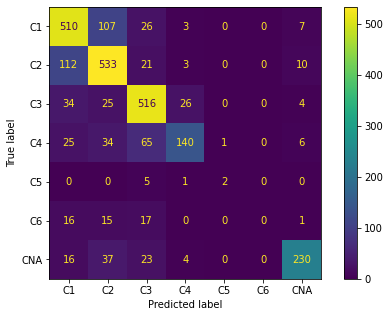

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_log_test, y_log_pred),
    display_labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CNA'],
)
cmp.plot(ax=ax)

# Using the params found in previous experiments

In [24]:
rfc_params = {'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 44,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 144}

In [25]:
rng = np.random.RandomState(0)

# X, y = make_classification(n_samples=700, random_state=rng)

clf = RandomForestClassifier(random_state=rng, **rfc_params)

In [18]:
# clf.fit(X_log_train, y_log_train)

NameError: name 'X_log_train' is not defined

In [17]:
# y_log_pred = clf.predict(X_log_test)

In [18]:
# f1_score(y_log_test, y_log_pred, average="weighted")

0.7405310670518199

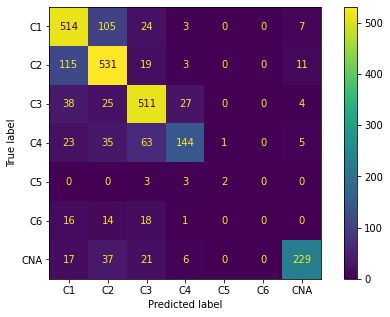

In [19]:
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_log_test, y_log_pred),
#     display_labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CNA'],
# )
# cmp.plot(ax=ax)

# Training on TCGA after uniform SVD transform

In [40]:
# pcawg_exps = pd.read_csv(input_dir + "tophat_star_fpkm_uq.v2_aliquot_gl_filtered.tsv", sep = "\t", index_col = 0, header = 0)

# pcawg_exps_np = pcawg_exps.to_numpy().transpose()

# pcawg_log = np.log(pcawg_exps_np + 1)

In [41]:
# pcawg_exps.shape

(52210, 1521)

In [24]:
# with open('npy_files/pcawg_log.npy', 'wb') as f:
#     np.save(f, pcawg_log)

In [20]:
pcawg_log = np.load('npy_files//pcawg_log.npy')

In [21]:
comb_exps = np.concatenate((exps_log, pcawg_log))

In [22]:
n_components = 200

In [23]:
embedder_svd_i = TruncatedSVD(n_components = n_components)
    
mod_log_all = embedder_svd_i.fit_transform(comb_exps)

tcga_set = mod_log_all[: exps_log.shape[0], :]
    
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    tcga_set, y, test_size=0.3, random_state=1121218
)

In [26]:
tcga_set.shape

(8582, 200)

In [27]:
clf.fit(X_log_train, y_log_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       max_features=44, min_samples_split=10, n_estimators=144,
                       random_state=RandomState(MT19937) at 0x7FF26D6D8740)

In [28]:
y_log_pred = clf.predict(X_log_test)

In [29]:
f1_score(y_log_test, y_log_pred, average="weighted")

0.7389675851941667

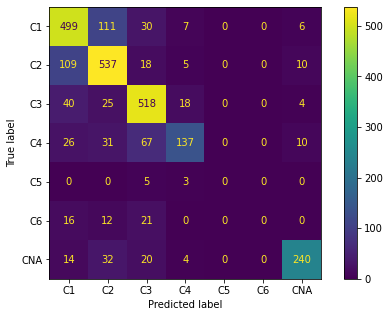

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_log_test, y_log_pred),
    display_labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CNA'],
)
cmp.plot(ax=ax)

In [31]:
pcawg_set = mod_log_all[exps_log.shape[0] :, :]

In [33]:
RF_pcawg_classes = clf.predict(pcawg_set)

In [36]:
collections.Counter(RF_pcawg_classes)

Counter({'C2': 436,
         'C1': 197,
         'C3': 524,
         'CNA': 249,
         'C4': 112,
         'C6': 1,
         'C5': 2})

## Dense neural networks

In [37]:
import tensorflow as tf
tf.config.run_functions_eagerly(True) 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input

from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers.normalization import BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import StratifiedKFold

2022-07-11 15:11:17.351260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /users/anna.hakobyan/centos/usr/lib:/users/anna.hakobyan/centos/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-07-11 15:11:17.351320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [56]:
model = Sequential()
# model.add(Embedding(vocab_size, Embedding_DIM, input_length=max_length))
# model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2) )
model.add(Dense(10, input_dim = 200, activation = 'relu'))
model.add(Dense(15, activation = 'relu'))
model.add(Dense(7, activation = 'sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])

print('Summary of the build model...')
print(model.summary())


Summary of the build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                2010      
                                                                 
 dense_7 (Dense)             (None, 15)                165       
                                                                 
 dense_8 (Dense)             (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________
None


### Categorical data encoding

In [57]:
enc = OneHotEncoder(handle_unknown='ignore', sparse = False)

y_ohe = enc.fit_transform(y.reshape(-1, 1))

In [58]:
X_log_train_ohe, X_log_test_ohe, y_log_train_ohe, y_log_test_ohe = train_test_split(
    tcga_set, y_ohe, test_size=0.3, random_state=1121218
)

In [59]:
num_epochs = 250
batch_size = 2000
history = model.fit(X_log_train_ohe, y_log_train_ohe,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    verbose = 2,
                    validation_split = 0.3)

# y_nn_pred = model.predict(X_log_test)

Epoch 1/250
3/3 - 0s - loss: 11.8859 - accuracy: 0.1981 - auc_2: 0.5908 - val_loss: 10.8382 - val_accuracy: 0.2335 - val_auc_2: 0.6066 - 140ms/epoch - 47ms/step
Epoch 2/250


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 - 0s - loss: 10.8541 - accuracy: 0.2274 - auc_2: 0.5990 - val_loss: 9.8951 - val_accuracy: 0.2457 - val_auc_2: 0.6136 - 92ms/epoch - 31ms/step
Epoch 3/250
3/3 - 0s - loss: 9.9022 - accuracy: 0.2381 - auc_2: 0.6053 - val_loss: 8.9849 - val_accuracy: 0.2501 - val_auc_2: 0.6193 - 91ms/epoch - 30ms/step
Epoch 4/250
3/3 - 0s - loss: 8.9775 - accuracy: 0.2471 - auc_2: 0.6111 - val_loss: 8.1073 - val_accuracy: 0.2518 - val_auc_2: 0.6247 - 90ms/epoch - 30ms/step
Epoch 5/250
3/3 - 0s - loss: 8.0932 - accuracy: 0.2510 - auc_2: 0.6159 - val_loss: 7.2598 - val_accuracy: 0.2540 - val_auc_2: 0.6306 - 90ms/epoch - 30ms/step
Epoch 6/250
3/3 - 0s - loss: 7.2359 - accuracy: 0.2540 - auc_2: 0.6213 - val_loss: 6.4467 - val_accuracy: 0.2562 - val_auc_2: 0.6366 - 91ms/epoch - 30ms/step
Epoch 7/250
3/3 - 0s - loss: 6.4090 - accuracy: 0.2586 - auc_2: 0.6281 - val_loss: 5.6710 - val_accuracy: 0.2596 - val_auc_2: 0.6447 - 90ms/epoch - 30ms/step
Epoch 8/250
3/3 - 0s - loss: 5.6219 - accuracy: 0.2624 - auc_2:

In [60]:
history

In [61]:
score, acc, auc = model.evaluate(X_log_test_ohe, y_log_test_ohe,
                            batch_size = batch_size, verbose = 2)


2/2 - 0s - loss: 0.6461 - accuracy: 0.7938 - auc_2: 0.9317 - 46ms/epoch - 23ms/step


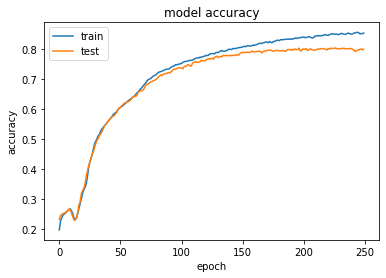

In [62]:
#plot the learniing rate curve
import numpy as np
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
y_log_pred_ohe_probs = model.predict(X_log_test_ohe)

81/81 [==============================] - 0s 2ms/step


In [64]:
y_log_pred_ohe = enc.inverse_transform(y_log_pred_ohe_probs)

In [65]:
f1_score(enc.inverse_transform(y_log_test_ohe), y_log_pred_ohe, average="weighted")

0.7843008591792626

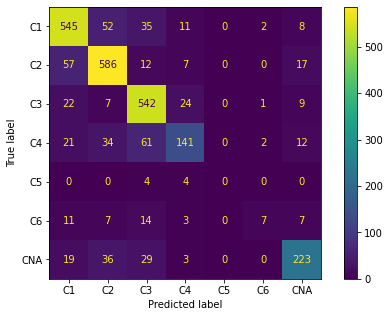

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(enc.inverse_transform(y_log_test_ohe), y_log_pred_ohe),
    display_labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CNA'],
)
cmp.plot(ax=ax)

In [67]:
DN_pcawg_probs = model.predict(pcawg_set)

48/48 [==============================] - 0s 3ms/step


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [78]:
DN_pcawg_classes = enc.inverse_transform(DN_pcawg_probs)
DN_pcawg_classes = DN_pcawg_classes[:, 0]

In [79]:
collections.Counter(DN_pcawg_classes)

Counter({'C2': 635,
         'C1': 128,
         'C3': 404,
         'CNA': 163,
         'C4': 172,
         'C5': 12,
         'C6': 7})

In [81]:
pcawg_classes = pd.DataFrame({'RF': RF_pcawg_classes, 'DN': DN_pcawg_classes})

In [82]:
pcawg_classes.to_csv('pcawg_predicted_classes.dat', sep = "\t")

## Reshaping log-expressions

In [66]:
X_log_train.shape

(6007, 200)

In [76]:
X_tcga_samples_mat = np.reshape(tcga_set, (-1, 10, 20))

In [86]:
y

array(['C1', 'C4', 'C3', ..., 'C3', 'C4', 'C4'], dtype=object)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X_tcga_samples_mat, y,
                                                    test_size=0.25, random_state=42)

In [79]:
X_tcga_samples_mat.shape

(8582, 10, 20)

In [80]:
img_rows, img_cols = len(x_test[0]), len(x_test[0][0])
num_classes = len(y_train[0])
batch_size = 128
epochs = 20
seed = 7
np.random.seed(seed)

In [83]:
img_cols, img_rows

(20, 10)

In [90]:
input_Xs = X_tcga_samples_mat
y_s = y_train

In [91]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

In [103]:
for j in range(10):
    i = 0
    for train, test in kfold.split(input_Xs, y_s):

        input_Xs = input_Xs.reshape(input_Xs.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        input_Xs = input_Xs.astype('float32')

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(y_s)
        # binary encode
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        num_classes = len(onehot_encoded[0])

        model = Sequential()
        ## *********** First layer Conv
        model.add(Conv2D(32, kernel_size=(1, img_rows), strides=(1, 1),
                         input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(1, 2))
        ## ********* Classification layer
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['categorical_accuracy'])
        callbacks = [EarlyStopping(monitor='categorical_accuracy', patience=3, verbose=0)]
        if i==0:
            model.summary()
            i = i +1
        history = model.fit(input_Xs[train], onehot_encoded[train],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0, callbacks=callbacks, validation_data=(input_Xs[test], onehot_encoded[test]))
        scores = model.evaluate(input_Xs[test], onehot_encoded[test], verbose=0)
        # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)

    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 10, 11, 32)        352       
                                                                 
 activation_1 (Activation)   (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               123008    
                                                                 
 dense_12 (Dense)            (None, 7)                 903       
                                                      

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.86% (+/- 1.11%)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 10, 11, 32)        352       
                                                                 
 activation_6 (Activation)   (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 960)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               123008    
                                                                 
 dense_22 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.63% (+/- 1.35%)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_11 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 960)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               123008    
                                                                 
 dense_32 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.44% (+/- 1.24%)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_16 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 960)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               123008    
                                                                 
 dense_42 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.30% (+/- 1.43%)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_21 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 960)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               123008    
                                                                 
 dense_52 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.41% (+/- 1.41%)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_26 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 960)               0         
                                                                 
 dense_61 (Dense)            (None, 128)               123008    
                                                                 
 dense_62 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.44% (+/- 1.34%)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_31 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 960)               0         
                                                                 
 dense_71 (Dense)            (None, 128)               123008    
                                                                 
 dense_72 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.46% (+/- 1.33%)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_36 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 960)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               123008    
                                                                 
 dense_82 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.44% (+/- 1.35%)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_41 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_41 (Flatten)        (None, 960)               0         
                                                                 
 dense_91 (Dense)            (None, 128)               123008    
                                                                 
 dense_92 (Dense)            (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.39% (+/- 1.33%)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 10, 11, 32)        352       
                                                                 
 activation_46 (Activation)  (None, 10, 11, 32)        0         
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_46 (Flatten)        (None, 960)               0         
                                                                 
 dense_101 (Dense)           (None, 128)               123008    
                                                                 
 dense_102 (Dense)           (None, 7)                 903       
                                  

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

77.38% (+/- 1.39%)


In [106]:
cvscores

[75.8540391921997,
 78.63247990608215,
 77.70007848739624,
 78.01088094711304,
 79.09867763519287,
 74.68944191932678,
 78.08857560157776,
 77.15617418289185,
 77.85547971725464,
 79.25407886505127,
 75.69875717163086,
 77.54467725753784,
 76.84537768363953,
 76.92307829856873,
 78.32167744636536,
 74.84471797943115,
 74.8251736164093,
 76.92307829856873,
 78.39937806129456,
 79.33177947998047,
 76.00931525230408,
 77.23387479782104,
 78.55477929115295,
 77.77777910232544,
 79.72028255462646,
 76.16459727287292,
 77.93318033218384,
 77.77777910232544,
 77.15617418289185,
 78.86558175086975,
 76.63043737411499,
 76.84537768363953,
 76.76767706871033,
 77.54467725753784,
 80.03107905387878,
 77.32919454574585,
 75.67987442016602,
 76.76767706871033,
 76.84537768363953,
 80.03107905387878,
 75.2329170703888,
 78.01088094711304,
 76.76767706871033,
 76.61227583885193,
 78.39937806129456,
 75.2329170703888,
 75.44677257537842,
 78.08857560157776,
 77.62237787246704,
 80.10877966880798]

### Dense NNs just with the immune genes

In [17]:
imm_train, imm_test, y_imm_train, y_imm_test = train_test_split(
    immune_exps_log, y_ohe, test_size=0.3, random_state=1121218
)

In [18]:
imm_train.shape


(6007, 2661)

In [56]:
model_imm = Sequential()
# model.add(Embedding(vocab_size, Embedding_DIM, input_length=max_length))
# model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2) )
model_imm.add(Dense(10, input_dim = 2661, activation = 'relu'))
model_imm.add(Dense(15, activation = 'relu'))
model_imm.add(Dense(7, activation = 'sigmoid'))

model_imm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])

print('Summary of the build model...')
print(model_imm.summary())


Summary of the build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                26620     
                                                                 
 dense_1 (Dense)             (None, 15)                165       
                                                                 
 dense_2 (Dense)             (None, 7)                 112       
                                                                 
Total params: 26,897
Trainable params: 26,897
Non-trainable params: 0
_________________________________________________________________
None


2022-07-04 19:26:50.707566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /users/anna.hakobyan/centos/usr/lib:/users/anna.hakobyan/centos/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-07-04 19:26:50.707628: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-04 19:26:50.707686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (clip-c2-37.cbe.vbc.ac.at): /proc/driver/nvidia/version does not exist
2022-07-04 19:26:50.708770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow wit

In [63]:
num_epochs = 500
batch_size = 2000
history = model_imm.fit(imm_train, y_imm_train,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    verbose = 2,
                    validation_split = 0.3)

# y_nn_pred = model.predict(X_log_test)

Epoch 1/500
3/3 - 0s - loss: 1.6293 - accuracy: 0.2747 - auc: 0.7359 - val_loss: 1.6272 - val_accuracy: 0.2696 - val_auc: 0.7332 - 164ms/epoch - 55ms/step
Epoch 2/500
3/3 - 0s - loss: 1.6290 - accuracy: 0.2747 - auc: 0.7360 - val_loss: 1.6269 - val_accuracy: 0.2696 - val_auc: 0.7332 - 103ms/epoch - 34ms/step
Epoch 3/500
3/3 - 0s - loss: 1.6288 - accuracy: 0.2747 - auc: 0.7360 - val_loss: 1.6266 - val_accuracy: 0.2696 - val_auc: 0.7332 - 106ms/epoch - 35ms/step
Epoch 4/500
3/3 - 0s - loss: 1.6285 - accuracy: 0.2747 - auc: 0.7360 - val_loss: 1.6263 - val_accuracy: 0.2696 - val_auc: 0.7332 - 105ms/epoch - 35ms/step
Epoch 5/500
3/3 - 0s - loss: 1.6283 - accuracy: 0.2747 - auc: 0.7360 - val_loss: 1.6260 - val_accuracy: 0.2696 - val_auc: 0.7332 - 112ms/epoch - 37ms/step
Epoch 6/500
3/3 - 0s - loss: 1.6280 - accuracy: 0.2747 - auc: 0.7360 - val_loss: 1.6257 - val_accuracy: 0.2696 - val_auc: 0.7332 - 102ms/epoch - 34ms/step
Epoch 7/500
3/3 - 0s - loss: 1.6278 - accuracy: 0.2747 - auc: 0.7355 -

In [64]:
score, acc, auc = model_imm.evaluate(imm_test, y_imm_test,
                            batch_size = batch_size, verbose = 2)


2/2 - 0s - loss: 1.6262 - accuracy: 0.2637 - auc: 0.7301 - 54ms/epoch - 27ms/step


In [65]:
imm_test

array([[0.19296961, 1.65226267, 1.88683899, ..., 0.04570698, 0.13456589,
        0.01656398],
       [0.16142643, 1.41071301, 1.30443727, ..., 0.04239299, 0.        ,
        0.01365313],
       [0.34680845, 2.19905358, 1.09437771, ..., 0.00680824, 0.        ,
        0.        ],
       ...,
       [0.06882469, 1.83651384, 2.65374265, ..., 0.06807711, 0.        ,
        0.06493525],
       [0.        , 2.32408845, 2.47940715, ..., 0.42991672, 0.        ,
        0.        ],
       [0.10960086, 1.79566758, 2.01893699, ..., 0.02358043, 0.        ,
        0.05310084]])

### Separately binding the immune genes and SVD other genes

In [12]:
embedder_100_svd = TruncatedSVD(n_components=100)
embedder_200_svd = TruncatedSVD(n_components=200)

In [13]:
imm_100_mod = embedder_100_svd.fit_transform(immune_exps_log)
non_imm_200_mod = embedder_200_svd.fit_transform(non_immune_exps_log)

In [14]:
imm_100_mod.shape

(8582, 100)

In [15]:
non_imm_200_mod.shape

(8582, 200)

In [16]:
imm_comb_exps = np.concatenate((imm_100_mod, non_imm_200_mod), axis = 1)

In [17]:
imm_comb_exps.shape

(8582, 300)

In [68]:
immc_train, immc_test, y_log_train, y_log_test = train_test_split(
    imm_comb_exps, y_ohe, test_size=0.3, random_state=1121218
)

In [71]:
model_immc = Sequential()
# model.add(Embedding(vocab_size, Embedding_DIM, input_length=max_length))
# model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2) )
model_immc.add(Dense(10, input_dim = 300, activation = 'relu'))
model_immc.add(Dense(15, activation = 'relu'))
model_immc.add(Dense(7, activation = 'sigmoid'))

model_immc.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])

print('Summary of the build model...')
print(model_immc.summary())

Summary of the build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                3010      
                                                                 
 dense_1 (Dense)             (None, 15)                165       
                                                                 
 dense_2 (Dense)             (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________
None


2022-07-05 16:31:55.385238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /users/anna.hakobyan/centos/usr/lib:/users/anna.hakobyan/centos/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-07-05 16:31:55.385334: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 16:31:55.385392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (clip-c2-17.cbe.vbc.ac.at): /proc/driver/nvidia/version does not exist
2022-07-05 16:31:55.386154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow wit

In [31]:
# img_rows, img_cols = len(x_test[0]), len(x_test[0][0])
# num_classes = len(y_train[0])
batch_size = 1000
epochs = 250
seed = 7
np.random.seed(seed)

In [47]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
immc_cvscores = []

In [49]:
for j in range(10):
    i = 0
    for train, test in kfold.split(imm_comb_exps, y):

        #         label_encoder = LabelEncoder()
        #         integer_encoded = label_encoder.fit_transform(y_s)
        #         # binary encode
        #         onehot_encoder = OneHotEncoder(sparse=False)
        #         integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        #         onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        #         num_classes = len(onehot_encoded[0])
        
        enc = OneHotEncoder(handle_unknown='ignore', sparse = False)

        y_ohe = enc.fit_transform(y.reshape(-1, 1))
        
        model_immc = Sequential()
        # model.add(Embedding(vocab_size, Embedding_DIM, input_length=max_length))
        # model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2) )
        model_immc.add(Dense(10, input_dim = 300, activation = 'relu'))
        model_immc.add(Dense(15, activation = 'relu'))
        model_immc.add(Dense(7, activation = 'sigmoid'))

        #       model = Sequential()
        #         ## *********** First layer Conv
        #         model.add(Conv2D(32, kernel_size=(1, img_rows), strides=(1, 1),
        #                          input_shape=input_shape))
        #         model.add(Activation('relu'))
        #         model.add(MaxPooling2D(1, 2))
        #         ## ********* Classification layer
        #         model.add(Flatten())
        #         model.add(Dense(128, activation='relu'))
        #         model.add(Dense(num_classes, activation='softmax'))
        #         model.compile(loss='categorical_crossentropy',
        #                       optimizer='adam',
        #                       metrics=['categorical_accuracy'])
        
        model_immc.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])
        
        callbacks = [EarlyStopping(monitor='categorical_accuracy', patience=3, verbose=0)]
        if i==0:
            model_immc.summary()
            i = i +1
        history = model_immc.fit(imm_comb_exps[train], y_ohe[train],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0, callbacks=callbacks, validation_data=(imm_comb_exps[test], y_ohe[test]))
        scores = model_immc.evaluate(imm_comb_exps[test], y_ohe[test], verbose=0)
        # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        immc_cvscores.append(scores[1] * 100)

    print("%.2f%% (+/- %.2f%%)" % (np.mean(immc_cvscores), np.std(immc_cvscores)))

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 10)                3010      
                                                                 
 dense_187 (Dense)           (None, 15)                165       
                                                                 
 dense_188 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.06% (+/- 0.81%)
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 10)                3010      
                                                                 
 dense_202 (Dense)           (None, 15)                165       
                                                                 
 dense_203 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.02% (+/- 0.92%)
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 10)                3010      
                                                                 
 dense_217 (Dense)           (None, 15)                165       
                                                                 
 dense_218 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.00% (+/- 1.03%)
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_231 (Dense)           (None, 10)                3010      
                                                                 
 dense_232 (Dense)           (None, 15)                165       
                                                                 
 dense_233 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.86% (+/- 1.06%)
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 10)                3010      
                                                                 
 dense_247 (Dense)           (None, 15)                165       
                                                                 
 dense_248 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.82% (+/- 1.07%)
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_261 (Dense)           (None, 10)                3010      
                                                                 
 dense_262 (Dense)           (None, 15)                165       
                                                                 
 dense_263 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.87% (+/- 1.15%)
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 10)                3010      
                                                                 
 dense_277 (Dense)           (None, 15)                165       
                                                                 
 dense_278 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.87% (+/- 1.10%)
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_291 (Dense)           (None, 10)                3010      
                                                                 
 dense_292 (Dense)           (None, 15)                165       
                                                                 
 dense_293 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.93% (+/- 1.13%)
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_306 (Dense)           (None, 10)                3010      
                                                                 
 dense_307 (Dense)           (None, 15)                165       
                                                                 
 dense_308 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.78% (+/- 1.31%)
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_321 (Dense)           (None, 10)                3010      
                                                                 
 dense_322 (Dense)           (None, 15)                165       
                                                                 
 dense_323 (Dense)           (None, 7)                 112       
                                                                 
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.74% (+/- 1.26%)


In [50]:
immc_cvscores

[79.84857559204102,
 79.90681529045105,
 79.54545617103577,
 78.96270155906677,
 79.89510297775269,
 80.8386743068695,
 81.94525241851807,
 80.59440851211548,
 79.48718070983887,
 79.54545617103577,
 81.65404796600342,
 79.38264608383179,
 80.36130666732788,
 80.01165390014648,
 78.32167744636536,
 82.0034921169281,
 80.780428647995,
 78.37995290756226,
 79.54545617103577,
 78.90442609786987,
 79.96505498886108,
 80.31449913978577,
 78.67133021354675,
 77.68065333366394,
 79.83682751655579,
 80.31449913978577,
 80.89691400527954,
 77.85547971725464,
 80.06992936134338,
 78.96270155906677,
 82.06173777580261,
 81.65404796600342,
 80.01165390014648,
 77.91375517845154,
 79.31235432624817,
 80.72218894958496,
 80.1980197429657,
 79.31235432624817,
 80.06992936134338,
 78.96270155906677,
 81.4210832118988,
 82.23645687103271,
 80.12820482254028,
 79.07925248146057,
 79.37062978744507,
 75.65521001815796,
 81.07163906097412,
 79.66200709342957,
 78.49650382995605,
 77.21444964408875,
 79.26

In [51]:
sum(immc_cvscores) / len(immc_cvscores)

79.74070776592602

In [44]:
cvscores

NameError: name 'cvscores' is not defined

In [33]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
total_exp_cvscores = []

In [42]:
for j in range(10):
    i = 0
    for train, test in kfold.split(tcga_set, y):

        #         label_encoder = LabelEncoder()
        #         integer_encoded = label_encoder.fit_transform(y_s)
        #         # binary encode
        #         onehot_encoder = OneHotEncoder(sparse=False)
        #         integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        #         onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        #         num_classes = len(onehot_encoded[0])
        
        enc = OneHotEncoder(handle_unknown='ignore', sparse = False)

        y_ohe = enc.fit_transform(y.reshape(-1, 1))
        
        model_total = Sequential()
        # model.add(Embedding(vocab_size, Embedding_DIM, input_length=max_length))
        # model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2) )
        model_total.add(Dense(10, input_dim = 200, activation = 'relu'))
        model_total.add(Dense(15, activation = 'relu'))
        model_total.add(Dense(7, activation = 'sigmoid'))

        #       model = Sequential()
        #         ## *********** First layer Conv
        #         model.add(Conv2D(32, kernel_size=(1, img_rows), strides=(1, 1),
        #                          input_shape=input_shape))
        #         model.add(Activation('relu'))
        #         model.add(MaxPooling2D(1, 2))
        #         ## ********* Classification layer
        #         model.add(Flatten())
        #         model.add(Dense(128, activation='relu'))
        #         model.add(Dense(num_classes, activation='softmax'))
        #         model.compile(loss='categorical_crossentropy',
        #                       optimizer='adam',
        #                       metrics=['categorical_accuracy'])
        
        model_total.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])
        
        callbacks = [EarlyStopping(monitor='categorical_accuracy', patience=3, verbose=0)]
        if i==0:
            model_total.summary()
            i = i +1
        history = model_total.fit(tcga_set[train], y_ohe[train],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0, callbacks=callbacks, validation_data=(tcga_set[test], y_ohe[test]))
        scores = model_total.evaluate(tcga_set[test], y_ohe[test], verbose=0)
        # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        total_exp_cvscores.append(scores[1] * 100)

    print("%.2f%% (+/- %.2f%%)" % (np.mean(total_exp_cvscores), np.std(total_exp_cvscores)))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                2010      
                                                                 
 dense_19 (Dense)            (None, 15)                165       
                                                                 
 dense_20 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.65% (+/- 0.87%)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                2010      
                                                                 
 dense_34 (Dense)            (None, 15)                165       
                                                                 
 dense_35 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.20% (+/- 1.65%)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 10)                2010      
                                                                 
 dense_49 (Dense)            (None, 15)                165       
                                                                 
 dense_50 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.29% (+/- 1.64%)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 10)                2010      
                                                                 
 dense_64 (Dense)            (None, 15)                165       
                                                                 
 dense_65 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.40% (+/- 1.53%)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 10)                2010      
                                                                 
 dense_79 (Dense)            (None, 15)                165       
                                                                 
 dense_80 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.44% (+/- 1.49%)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 10)                2010      
                                                                 
 dense_94 (Dense)            (None, 15)                165       
                                                                 
 dense_95 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80.02% (+/- 1.97%)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 10)                2010      
                                                                 
 dense_109 (Dense)           (None, 15)                165       
                                                                 
 dense_110 (Dense)           (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.90% (+/- 2.33%)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 10)                2010      
                                                                 
 dense_124 (Dense)           (None, 15)                165       
                                                                 
 dense_125 (Dense)           (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.84% (+/- 2.42%)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 10)                2010      
                                                                 
 dense_139 (Dense)           (None, 15)                165       
                                                                 
 dense_140 (Dense)           (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.70% (+/- 2.70%)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 10)                2010      
                                                                 
 dense_154 (Dense)           (None, 15)                165       
                                                                 
 dense_155 (Dense)           (None, 7)                 112       
                                                                 
Total params: 2,287
Trainable params: 2,287
Non-trainable params: 0
_________________________________________________________________


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79.77% (+/- 2.59%)


In [52]:
total_exp_cvscores

[82.29470252990723,
 81.36284351348877,
 79.42890524864197,
 80.41958212852478,
 80.8857798576355,
 80.95515370368958,
 80.13978004455566,
 80.12820482254028,
 81.41025900840759,
 79.42890524864197,
 74.78159666061401,
 81.36284351348877,
 80.53613305091858,
 79.54545617103577,
 80.36130666732788,
 82.81887173652649,
 80.60570955276489,
 77.97203063964844,
 81.2937080860138,
 80.01165390014648,
 82.4111819267273,
 80.37274479866028,
 80.8857798576355,
 80.12820482254028,
 80.47785758972168,
 81.94525241851807,
 81.4210832118988,
 81.3519835472107,
 78.37995290756226,
 79.95337843894958,
 79.90681529045105,
 75.88817477226257,
 73.31002354621887,
 79.42890524864197,
 78.96270155906677,
 81.07163906097412,
 81.30460381507874,
 81.41025900840759,
 80.47785758972168,
 71.21211886405945,
 81.94525241851807,
 79.32440042495728,
 80.9440553188324,
 73.65967631340027,
 80.8857798576355,
 70.00582218170166,
 80.13978004455566,
 81.17715716362,
 79.25407886505127,
 81.81818127632141,
 81.5958082

In [53]:
sum(total_exp_cvscores) / len(total_exp_cvscores)

79.77048689668828